In [2]:
from sklearn.cluster import KMeans
import pandas as pd
import dask.dataframe as dd
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np
import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Input, Flatten, Dot, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [3]:
scores = pd.read_csv('../data/ml-32m/ratings.csv')
#scores = pd.read_csv('../data/scores.csv')
movies = pd.read_csv('../data/ml-32m/movies.csv')
users = pd.read_csv('../data/ml-32m/users.csv')

print(scores.head())
print(movies.head())
print(users.head())


   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   id  Occupation         Active Since
0   1  technician  1998-04-05 05:50:59
1   2       other  1998-06-10 09:16:44
2   3      writer  1998-05-07 12:06:40
3   4  technician  19

In [4]:
print(scores['rating'].describe())  # Revisa estadísticas descriptivas


count    3.200020e+07
mean     3.540396e+00
std      1.058986e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


In [5]:
scores['userId'].nunique()

200948

In [6]:
scores = scores[['userId', 'movieId', 'rating']]

In [7]:
scores

,userId,movieId,rating
0,1,17,4.0
1,1,25,1.0
2,1,29,2.0
3,1,30,5.0
4,1,32,5.0
...,...,...,...
32000199,200948,79702,4.5
32000200,200948,79796,1.0
32000201,200948,80350,0.5
32000202,200948,80463,3.5


In [8]:
# Verificamos los valores únicos en 'userId' y 'movieId' para asegurarse de que no hay valores negativos
print("Valores únicos de userId:", scores['userId'].unique()[:10])  # Muestra los primeros 10 valores
print("Valores únicos de movieId:", scores['movieId'].unique()[:10])  # Muestra los primeros 10 valores

# Verificamos el rango de 'userId' y 'movieId'
print(f"Rango de 'userId': {scores['userId'].min()} a {scores['userId'].max()}")
print(f"Rango de 'movieId': {scores['movieId'].min()} a {scores['movieId'].max()}")



Valores únicos de userId: [ 1  2  3  4  5  6  7  8  9 10]
Valores únicos de movieId: [ 17  25  29  30  32  34  36  80 110 111]
Rango de 'userId': 1 a 200948
Rango de 'movieId': 1 a 292757


######  Método del Codo
Este código realiza el análisis del método del codo para determinar el número óptimo de clusters y muestra el gráfico de inercia (SSE).

Muestra Representativa: Se toma un 1% de los datos para optimizar el rendimiento del modelo. Desde los computacional y alineamiento de datos.
Escalado de Datos: Se normalizan las características para asegurar que todas tengan el mismo rango.
Método del Codo: Se ejecuta K-Means para varios valores de k (1 a 10) y se calcula la inercia. 
El gráfico te permitirá observar el "codo" para elegir el número óptimo de clusters.


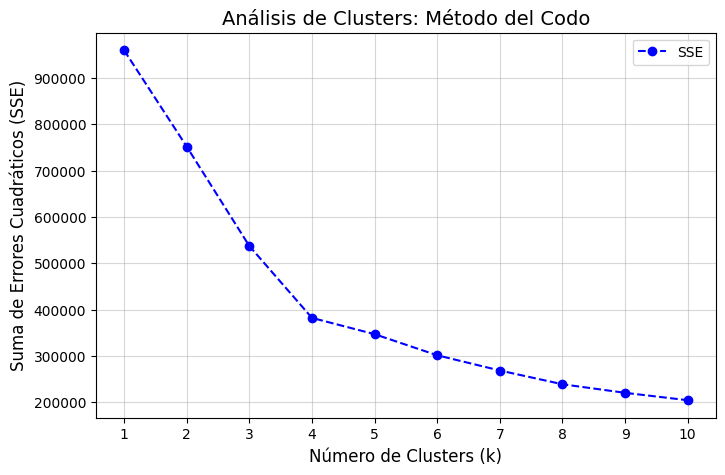

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# ===========================================
# MUESTRA REPRESENTATIVA
# ===========================================
sample_size = int(0.01 * len(scores))  # Reducimos el tamaño de la muestra tomada del Dataset movielens 32k a 320.000 datos para optimizar al modelo.
np.random.seed(42)  # Control de aleatoriedad
sample_indices = np.random.choice(scores.shape[0], sample_size, replace=False)
scores_sampled = scores.iloc[sample_indices]

# ===========================================
# ESCALADO DE DATOS
# ===========================================
scaler = StandardScaler()
scores_scaled = scaler.fit_transform(scores_sampled)

# ===========================================
# MÉTODO DEL CODO
# ===========================================
sse = []  # Para almacenar la suma de errores cuadráticos
k_range = range(1, 11)  # Probar k entre 1 y 10

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto')
    kmeans.fit(scores_scaled)
    sse.append(kmeans.inertia_)

# Visualización del método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o', linestyle='--', color='b', label="SSE")
plt.title('Análisis de Clusters: Método del Codo', fontsize=14)
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Suma de Errores Cuadráticos (SSE)', fontsize=12)
plt.xticks(k_range)
plt.grid(alpha=0.5)
plt.legend()
plt.show()





c:\Users\Luis\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


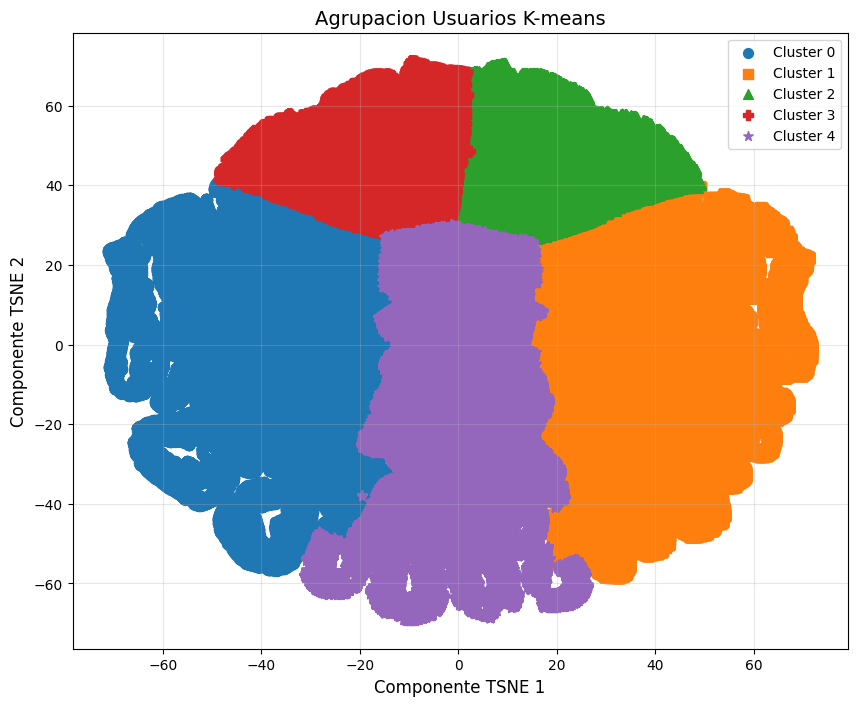

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# =======================
# 1. MUESTRA REPRESENTATIVA
# =======================
sample_size = int(0.01 * len(scores))  # Redujimos el tamaño de la muestra a 320.000 datos para la optimización del modelo. 
scores_sampled = scores.sample(n=sample_size, random_state=42)

# =======================
# 2. REDUCCIÓN DE DIMENSIONALIDAD CON PCA
# =======================
n_components = min(50, scores_sampled.shape[1])  # Establecer el número de componentes según las dimensiones de los datos
pca = PCA(n_components=n_components, random_state=42)
scores_pca = pca.fit_transform(scores_sampled)

# =======================
# 3. APLICA K-MEANS
# =======================
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10)  # Usar un valor adecuado para n_init
clusters = kmeans.fit_predict(scores_pca)

# =======================
# 4. REDUCCIÓN DE DIMENSIONALIDAD CON t-SNE
# =======================
tsne = TSNE(n_components=2, random_state=42, method='barnes_hut', n_iter=500)
reduced_embeddings = tsne.fit_transform(scores_pca)

# =======================
# 5. VISUALIZACIÓN DE LOS CLUSTERS CON PUNTOS Y DIFERENTES ESTILOS DE MARCADORES
# =======================
markers = ['o', 's', '^', 'P', '*']
plt.figure(figsize=(10, 8))

for i in range(5):
    cluster_points = reduced_embeddings[clusters == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                marker=markers[i], label=f'Cluster {i}', s=50)  # 's' es el tamaño de los puntos

# Agregar título y etiquetas
plt.title('Agrupacion Usuarios K-means', fontsize=14)
plt.xlabel('Componente TSNE 1', fontsize=12)
plt.ylabel('Componente TSNE 2', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Mostrar el gráfico
plt.show()




In [13]:
# Ver los centroides de cada cluster
centroids = kmeans.cluster_centers_
print("Centroides de los clusters:")
print(centroids)


Centroides de los clusters:
[[-6.68763158e+04 -2.02395653e+04 -5.33820228e-03]
 [ 6.73660577e+04 -2.05512681e+04  2.37276210e-03]
 [ 5.06581785e+04  9.22327440e+04  3.94666471e-04]
 [-4.91646475e+04  1.00330913e+05  2.27317179e-02]
 [-1.04845887e+02 -1.97581998e+04 -4.11367679e-03]]


In [24]:
# se tomaron 320.000 muestras al azar con usuarios, movieID y el rating por cada una de las categorias. K means pudo agrugar por tipo de ratings a los usuarios.
scores_sampled 

,userId,movieId,rating,cluster
10685861,66954,781,5.0,4
1552723,9877,574,4.0,0
6145184,38348,1088,2.0,0
16268584,101952,2706,1.0,4
22418634,140400,275079,3.5,2
...,...,...,...,...
845560,5547,4874,4.0,0
31137879,195512,97860,3.0,2
1290260,8307,8610,3.0,0
23987003,150344,66934,4.0,2


In [ ]:
# ============================================================================================
# ANALISIS DE LOS CLUSTERS AGRUPADOS POR USUARIOS BASADOS EN PREFERENCIAS SEGUN CALIFICACIONES
# ============================================================================================
cluster_description = {}

for cluster_num in range(5):
    # Filtramos los datos por el número del cluster
    cluster_data = scores_sampled[scores_sampled['cluster'] == cluster_num]
    
    # Características que pueden ser relevantes para cada cluster
    # Número de calificaciones por usuario en este cluster
    num_ratings = cluster_data.groupby('userId')['rating'].count()
    
    # Analizamos la dispersión de las calificaciones (desviación estándar)
    rating_dispersion = cluster_data.groupby('userId')['rating'].std()
    
    # Podemos analizar si los usuarios en este cluster son más estrictos o generosos en sus calificaciones
    max_rating = cluster_data.groupby('userId')['rating'].max()
    min_rating = cluster_data.groupby('userId')['rating'].min()

    # Guardamos la descripción para cada cluster, más detalles sin promedios
    cluster_description[cluster_num] = {
        'num_ratings': num_ratings.describe(),  # Distribución del número de calificaciones por usuario
        'rating_dispersion': rating_dispersion.describe(),  # Dispersión de las calificaciones por usuario
        'max_rating': max_rating.describe(),  # Máximas calificaciones por usuario
        'min_rating': min_rating.describe(),  # Mínimas calificaciones por usuario
    }

# Mostrar el análisis detallado de los clusters
for cluster_num, description in cluster_description.items():
    print(f"\nCluster {cluster_num} - Características destacadas:")
    print(f"Distribución del número de calificaciones por usuario:\n{description['num_ratings']}")
    print(f"Dispersión de las calificaciones por usuario (desviación estándar):\n{description['rating_dispersion']}")
    print(f"Máximas calificaciones por usuario:\n{description['max_rating']}")
    print(f"Mínimas calificaciones por usuario:\n{description['min_rating']}")




Cluster 0 - Características destacadas:
Distribución del número de calificaciones por usuario:
count    34616.000000
mean         2.554397
std          2.886167
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         89.000000
Name: rating, dtype: float64
Dispersión de las calificaciones por usuario (desviación estándar):
count    17846.000000
mean         0.783083
std          0.551670
min          0.000000
25%          0.353553
50%          0.707107
75%          1.060660
max          3.181981
Name: rating, dtype: float64
Máximas calificaciones por usuario:
count    34616.000000
mean         4.037324
std          0.932246
min          0.500000
25%          3.500000
50%          4.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64
Mínimas calificaciones por usuario:
count    34616.000000
mean         3.236047
std          1.189453
min          0.500000
25%          2.500000
50%          3.500000
75%          4.00

## CONCLUSIONES FINALES :

*Cluster 0:

Promedio de calificaciones por usuario: Los usuarios en este grupo tienen un promedio de 2.55 calificaciones por usuario. La distribución es amplia, con usuarios que califican solo unos pocos elementos (alrededor de 1 calificación) hasta usuarios más activos que hacen hasta 89 calificaciones.

Dispersión de calificaciones: Los usuarios en este cluster tienen una desviación estándar de 0.78 en sus calificaciones, lo que indica que las calificaciones varían moderadamente entre ellos, con una mayor dispersión.
Máximas y mínimas calificaciones: Los usuarios tienden a dar calificaciones cercanas al máximo, con un promedio de 4.04 para las calificaciones más altas y 3.24 para las más bajas. Esto sugiere que los usuarios en este cluster tienden a calificar de manera positiva, pero también existe una proporción significativa de calificaciones medias o bajas.


*Cluster 1:

Promedio de calificaciones por usuario: Similar al Cluster 0, con un promedio de 2.52 calificaciones por usuario, lo que indica un comportamiento de calificación relativamente moderado. Sin embargo, el número máximo de calificaciones por usuario es más alto, hasta 96 calificaciones.

Dispersión de calificaciones: Al igual que en el Cluster 0, la desviación estándar es de 0.78, lo que refleja una variabilidad moderada en las calificaciones de los usuarios.
Máximas y mínimas calificaciones: Los usuarios en este cluster también muestran una tendencia a dar calificaciones altas (promedio de 4.04), con mínimas cercanas a 3.24. Esto sugiere que, aunque se distribuyen más en cantidad de calificaciones, en términos de evaluación, son bastante consistentes y mayormente positivas.


*Cluster 2:

Promedio de calificaciones por usuario: Este grupo tiene un número promedio de calificaciones por usuario significativamente más bajo (2.02), lo que sugiere que estos usuarios son menos activos en términos de cantidad de calificaciones. Sin embargo, hay usuarios con un número alto de calificaciones (hasta 223).

Dispersión de calificaciones: Con una desviación estándar de 0.72, los usuarios en este cluster tienen una calificación más consistente en comparación con los clusters anteriores.
Máximas y mínimas calificaciones: Las calificaciones altas tienen un promedio de 3.92, mientras que las bajas son de 3.38. Esto refleja un grupo que tiende a calificar dentro de un rango medio-alto, con menos variabilidad entre sus evaluaciones.


*Cluster 3:

Promedio de calificaciones por usuario: Los usuarios en este cluster tienen un promedio de 2.02 calificaciones, similar al Cluster 2, pero con un rango de calificaciones algo más bajo, con un máximo de 43 calificaciones.

Dispersión de calificaciones: La desviación estándar es de 0.70, que es la más baja entre los clusters, lo que indica una calificación más uniforme entre los usuarios.
Máximas y mínimas calificaciones: Las máximas calificaciones promedian 3.92, mientras que las mínimas promedian 3.39, lo que muestra una tendencia hacia calificaciones positivas, pero con una ligera preferencia por calificaciones más altas en comparación con otros grupos.


*Cluster 4:

Promedio de calificaciones por usuario: Los usuarios en este grupo tienen un promedio de 2.55 calificaciones, con una distribución similar a la de los clusters 0 y 1, pero con un máximo de 57 calificaciones por usuario.

Dispersión de calificaciones: La desviación estándar es de 0.77, lo que indica una variabilidad moderada en las calificaciones.
Máximas y mínimas calificaciones: Las calificaciones más altas tienen un promedio de 4.03, y las más bajas tienen un promedio de 3.24. Esto sugiere un comportamiento de calificación predominantemente positivo, similar al de los otros clusters.

###### Conclusión General:

Los cinco clusters presentan comportamientos similares en términos de calificaciones: los usuarios tienden a calificar de manera positiva, con un promedio de calificación cercano al rango alto (4.0). 

Sin embargo, hay algunas diferencias en cuanto a la cantidad de calificaciones realizadas y la dispersión entre los usuarios.

Clusters 0, 1 y 4: Los usuarios son relativamente activos, con un número promedio de calificaciones que varía entre 2.5 y 2.6. Los rangos de dispersión y calificaciones máximas son bastante similares en estos clusters.

Clusters 2 y 3: Los usuarios tienden a ser menos activos, con un número promedio de calificaciones más bajo (alrededor de 2), pero muestran una consistencia similar en sus calificaciones, con calificaciones ligeramente más altas en comparación con los otros grupos.

En general, estos clusters reflejan una segmentación de usuarios basada en su actividad de calificación, con una clara inclinación hacia calificaciones positivas en todos los casos. Las diferencias clave entre los grupos radican en la cantidad de interacciones (calificaciones) y la consistencia en las evaluaciones.






